# ⚠️ 본 노트북은 실제 데이터를 포함하지 않으며, 구조 학습을 위한 예시 기반 더미 데이터만 포함됩니다.

# 라이브러리

In [1]:
! pip3 install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.3 MB/s eta 0:00:00


In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from faker import Faker
import random

In [4]:
fake = Faker()
Faker.seed(0)
np.random.seed(0)
random.seed(0)

# 구성할 컬럼: Unnamed: 0, user_uuid, URL, timestamp, date, response_code, method, cleaned_url
num_rows = 1000  # 예시로 1000개 생성

dummy_data = {
    "Unnamed: 0": range(num_rows),
    "user_uuid": [fake.uuid4() for _ in range(num_rows)],
    "URL": [random.choice([
        "api/signup/form",
        "api/search/language?name=영어",
        "api/users/id/template",
        "verify_phone?next_url=/@testuser",
        "@user_id",
        "api/login/verify?session_id=12345",
        "api/job/detail?job_id=5678"
    ]) for _ in range(num_rows)],
    "timestamp": [fake.date_time_between(start_date="-30d", end_date="now") for _ in range(num_rows)],
    "date": [fake.date_between(start_date="-30d", end_date="today") for _ in range(num_rows)],
    "response_code": [random.choice([200, 201, 400, 401, 403, 404, 500]) for _ in range(num_rows)],
    "method": [random.choice(["GET", "POST", "PUT", "DELETE"]) for _ in range(num_rows)],
    "cleaned_url": []  # URL에서 query string 제거한 형태
}

# cleaned_url 생성
for url in dummy_data["URL"]:
    base = url.split("?")[0]
    dummy_data["cleaned_url"].append(base)

# DataFrame 생성
dummy_log_df = pd.DataFrame(dummy_data)
dummy_log_df.head()

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,0,e3e70682-c209-4cac-a29f-6fbed82c07cd,api/job/detail?job_id=5678,2025-06-05 09:49:23.646330,2025-06-01,403,POST,api/job/detail
1,1,f728b4fa-4248-4e3a-8a5d-2f346baa9455,verify_phone?next_url=/@testuser,2025-06-26 18:38:01.922826,2025-06-22,201,DELETE,verify_phone
2,2,eb1167b3-67a9-4378-bc65-c1e582e2e662,api/job/detail?job_id=5678,2025-06-05 01:19:20.465526,2025-06-12,400,POST,api/job/detail
3,3,f7c1bd87-4da5-4709-9471-3d60c8a70639,verify_phone?next_url=/@testuser,2025-06-04 16:26:33.111606,2025-06-02,401,DELETE,verify_phone
4,4,e443df78-9558-467f-9ba9-1faf7a024204,api/signup/form,2025-06-04 12:22:00.132908,2025-06-27,404,POST,api/signup/form


# UTM 파라미터 분석

## UTM 파라미터 추출 및 정제

In [5]:
import re

# UTM 파라미터가 포함된 URL만 필터링
utm_mask = dummy_log_df["URL"].str.contains("utm_", na=False)
utm_only_df = dummy_log_df[utm_mask].copy()

# UTM 파라미터 추출 함수 (정규표현식 기반)
def fast_extract_utm(url, key):
    match = re.search(f"{key}=([^&]+)", url)
    return match.group(1) if match else None

# 각 UTM 항목별로 추출
utm_only_df["utm_source"] = utm_only_df["URL"].apply(lambda x: fast_extract_utm(x, "utm_source"))
utm_only_df["utm_medium"] = utm_only_df["URL"].apply(lambda x: fast_extract_utm(x, "utm_medium"))
utm_only_df["utm_campaign"] = utm_only_df["URL"].apply(lambda x: fast_extract_utm(x, "utm_campaign"))
utm_only_df["utm_content"] = utm_only_df["URL"].apply(lambda x: fast_extract_utm(x, "utm_content"))
utm_only_df["utm_term"] = utm_only_df["URL"].apply(lambda x: fast_extract_utm(x, "utm_term"))

# 원래 데이터프레임과 병합
dummy_log_df = dummy_log_df.merge(utm_only_df[["Unnamed: 0", "utm_source", "utm_medium", "utm_campaign", "utm_content", "utm_term"]], on="Unnamed: 0", how="left")
dummy_log_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,utm_source,utm_medium,utm_campaign,utm_content,utm_term
0,0,e3e70682-c209-4cac-a29f-6fbed82c07cd,api/job/detail?job_id=5678,2025-06-05 09:49:23.646330,2025-06-01,403,POST,api/job/detail,NaN,NaN,NaN,NaN,NaN
1,1,f728b4fa-4248-4e3a-8a5d-2f346baa9455,verify_phone?next_url=/@testuser,2025-06-26 18:38:01.922826,2025-06-22,201,DELETE,verify_phone,NaN,NaN,NaN,NaN,NaN
2,2,eb1167b3-67a9-4378-bc65-c1e582e2e662,api/job/detail?job_id=5678,2025-06-05 01:19:20.465526,2025-06-12,400,POST,api/job/detail,NaN,NaN,NaN,NaN,NaN
3,3,f7c1bd87-4da5-4709-9471-3d60c8a70639,verify_phone?next_url=/@testuser,2025-06-04 16:26:33.111606,2025-06-02,401,DELETE,verify_phone,NaN,NaN,NaN,NaN,NaN
4,4,e443df78-9558-467f-9ba9-1faf7a024204,api/signup/form,2025-06-04 12:22:00.132908,2025-06-27,404,POST,api/signup/form,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,dbb59fc2-5cff-496e-bd03-c81f7ff35029,verify_phone?next_url=/@testuser,2025-06-16 18:21:43.350704,2025-06-02,200,GET,verify_phone,NaN,NaN,NaN,NaN,NaN
996,996,6e935faf-9502-41d5-967a-d0895acecdbf,api/search/language?name=영어,2025-05-30 21:36:48.071975,2025-05-30,500,GET,api/search/language,NaN,NaN,NaN,NaN,NaN
997,997,0654f465-b311-49c4-9d86-fd12c8359b91,api/search/language?name=영어,2025-06-09 19:45:29.956094,2025-06-26,400,PUT,api/search/language,NaN,NaN,NaN,NaN,NaN
998,998,98082cf3-03a7-49aa-ac14-af79c4a0c1cd,verify_phone?next_url=/@testuser,2025-06-08 09:16:51.806774,2025-06-22,500,PUT,verify_phone,NaN,NaN,NaN,NaN,NaN


## UTM 유입량 분석

<Axes: title={'center': '일별 UTM 유입량 추이'}, xlabel='date'>

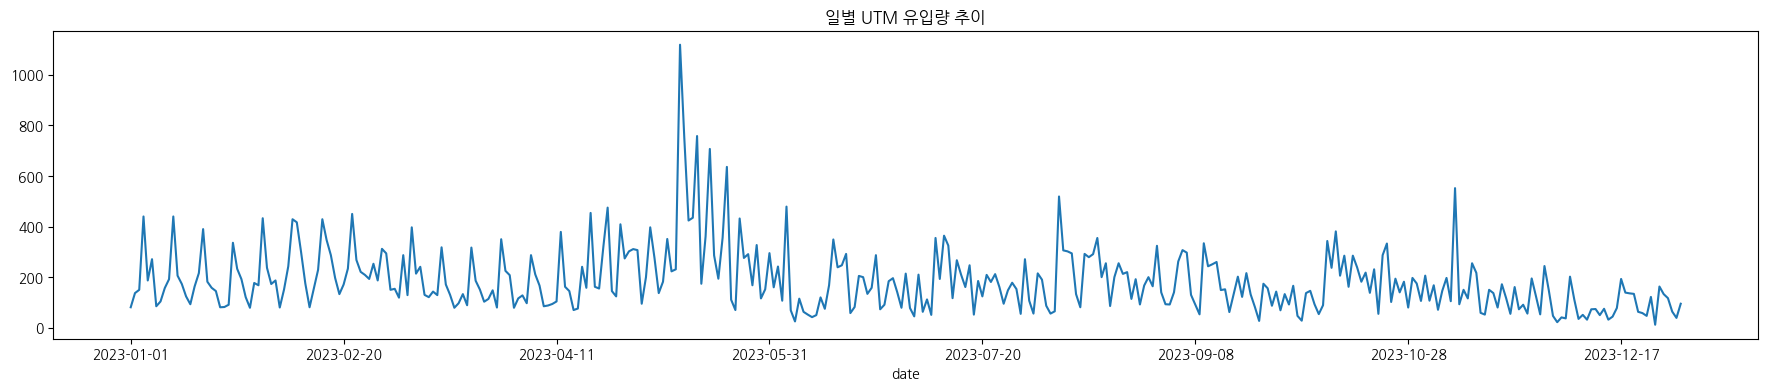

In [ ]:
utm_source = log_2023_df[log_2023_df["utm_source"].notna()]
utm_daily = utm_source.groupby("date").size()

utm_daily.plot(kind="line", title="일별 UTM 유입량 추이", figsize=(22, 4))

- 2022년에는 전반적으로 일정한 범위 내에서 균일하게 유입되었으나
- 2023년에는 특정 구간(4월 말 ~ 5월 초, 10월 말 ~ 11월 초)에서 값이 튀는 것을 확인
    - 특정 시기에 수행한 캠페인이 효과적이였음을 알 수 있음

## UTM별 행동 분석

```python
# 실제 데이터 결과
utm_behavior = (
    log_2023_df[log_2023_df["utm_source"].notna()]
    .groupby(["utm_source", "utm_medium", "method"])["method"]
    .count()
    .unstack(fill_value=0)
    .reset_index()
)

utm_behavior
```

|method|utm_source|utm_medium|GET|POST|
|---|---|---|---|---|
|0|(해당 플랫폼)+Newsletter|email|3|0|
|1|email|email|70|0|
|2|excel|alink|28638|0|
|3|facebook|social|2|0|
|4|google_jobs_apply|organic|745|0|
|5|iweb|marketing|99|0|
|6|kakaochatbot|organic|1|0|
|7|notification|email|37445|45|

## 캠페인별 행동 횟수 집계

```python
# 캠페인별 클릭 수 (실제 데이터)
campaign_clicks = log_2023_df["utm_campaign"].value_counts()
print("캠페인별 클릭 수")
print(campaign_clicks)
```

- 2023년도 결과

```
캠페인별 클릭 수
utm_campaign
jobs                                              17543
company                                           11037
job_matching                                       8919
recommend_people                                   2671
application_open                                   1544
                                                  ...  
company 임시 필터 1 범위: A1:M188                           1
jobs3Da7ec83fdd63b4d75786102c1541da4b5d44ccfe8        1
jobs2                                                 1
cs                                                    1
facebook_close                                        1
Name: count, Length: 74, dtype: int64
```

- 2022년도 결과

```
캠페인별 클릭 수
utm_campaign
job_matching                      11736
recommend_people                   7995
google_jobs_apply                  4999
job_offer                          3610
friend_request                     3392
                                  ...  
failed                                1
job_ad                                1
uxuidesigner_f                        1
advertisement                         1
fb0295e2a2-Newsletter_155_2015        1
```

- 2022년과 다르게 jobs, company가 가장 많이 클릭됨

## source + medium 조합

```python
# source + medium 조합으로 유입 경로 분석 (실제 데이터)
source_medium = log_2023_df.groupby(["utm_source", "utm_medium"]).size().reset_index(name="count")
source_medium = source_medium.sort_values(by="count", ascending=False)

print("UTM 유입 경로 (source + medium)")
print(source_medium)
```

- 2023년도 결과

```
UTM 유입 경로 (source + medium)
               utm_source utm_medium  count
7            notification      email  37490
2                   excel      alink  28638
4       google_jobs_apply    organic    745
5                    iweb  marketing     99
1                   email      email     70
0  (해당 플랫폼)+Newsletter      email      3
3                facebook     social      2
6            kakaochatbot    organic      1
```

- 2022년도 결과

```
UTM 유입 경로 (source + medium)
                utm_source     utm_medium  count
13            notification          email  64102
6        google_jobs_apply        organic   4975
8                     iweb      marketing     23
0   (해당 플랫폼)+Newsletter          email     10
15              wnc_594600          gamma      9
12              linktree_n         social      9
4                 facebook           post      4
5                 facebook         social      4
7                instagram          click      4
2                   brunch         social      2
1      (해당 플랫폼)+Recruit          email      1
3                    email          email      1
11                linkedin         social      1
10            kakaochatbot        organic      1
9               job_widget         widget      1
14                  widget  advertisement      1
```

- 2022년과 다르게 excel, alink를 통한 유입이 새롭게 생기고 수가 매우 많음

## 콘텐츠 유형 분석

```python
# 실제 데이터
content_counts = log_2023_df["utm_content"].value_counts()
print("어떤 콘텐츠가 클릭을 유도했는가?")
print(content_counts.head(10))
```

```
어떤 콘텐츠가 클릭을 유도했는가?
utm_content
view_job                    16383
view_company                 6623
email_setting                1444
view_application_button      1387
view_job_button              1358
experience_verify_button     1340
verify_button                1071
offer_check                   744
reset_button                  596
job_company                   592
Name: count, dtype: int64
```

## UTM 유입 → 행동 분석 (전환 퍼널 분석)

```python
# UTM 파라미터가 하나라도 존재하는 행만 필터링 (실제 데이터)
utm_df = log_2023_df[
    log_2023_df["utm_source"].notna() |
    log_2023_df["utm_medium"].notna() |
    log_2023_df["utm_campaign"].notna() |
    log_2023_df["utm_content"].notna() |
    log_2023_df["utm_term"].notna()
]

# 회원가입 로그
signup_logs = log_2023_df[log_2023_df["URL"].str.contains("api/signup/form", na=False)]

# 프로필 작성 로그
profile_logs = log_2023_df[log_2023_df["URL"].str.contains("api/users/id/(template|form|education|experience|project|language|career|award)", na=False)]

# 지원 로그
apply_logs = log_2023_df[log_2023_df["URL"].str.contains("apply", na=False)]

# 각 행동을 한 사용자 UUID 집합 생성
signup_users = set(signup_logs["user_uuid"])
profile_users = set(profile_logs["user_uuid"])
apply_users = set(apply_logs["user_uuid"])

# UTM 유입된 사용자 UUID 집합
utm_users = set(utm_df["user_uuid"])

def calc_conversion_rate(action_users, total_users):
    if len(total_users) == 0:
        return 0
    return round(len(action_users & total_users) / len(total_users) * 100, 2)

signup_conversion = calc_conversion_rate(signup_users, utm_users)
profile_conversion = calc_conversion_rate(profile_users, utm_users)
apply_conversion = calc_conversion_rate(apply_users, utm_users)

print("전환율 (UTM 유입 사용자 기준)")
print(f"회원가입 전환율: {signup_conversion}%")
print(f"프로필 작성 전환율: {profile_conversion}%")
print(f"지원 전환율: {apply_conversion}%")
```

- 2022년도 결과

```
전환율 (UTM 유입 사용자 기준)
회원가입 전환율: 9.52%
프로필 작성 전환율: 96.55%
지원 전환율: 67.78%
```

- 회원가입 전환율: 9.52%
    - UTM 유입 사용자 중 약 9.5%가 실제로 회원가입을 완료
    - 수치가 상대적으로 낮은 이유
        - 회원가입 과정에서 복잡함이나 장애물이 있을 수 있음
        - 회원가입 과정에서 유입된 사용자의 참여를 더 유도할 수 있는 방법을 찾아볼 필요 있음

- 프로필 작성 전환율: 96.55%
    - UTM 유입 사용자 중 대부분이 프로필 작성
    - 플랫폼의 사용성이 잘 반영된 부분
        - 그러나, 값이 너무 높아 실제 활동을 의미하는지 또는 프로필 작성만 이루어졌는지를 더 살펴볼 필요 있음

- 지원 전환율: 67.78%
    - UTM 유입 사용자 중 약 67.8%가 실제로 지원 (상당히 높은 전환율)
    - 하지만, 지원 과정에서 일부 사용자가 중단되거나 이탈하는 점도 고려해야 함
        - 이 전환율이 낮다고 느껴지면, 지원 프로세스에서 장애물이 있을 수 있으니 그 부분을 최적화할 방법을 찾아볼 필요 있음

- 2023년도 결과

```
전환율 (UTM 유입 사용자 기준)
회원가입 전환율: 10.25%
프로필 작성 전환율: 95.28%
지원 전환율: 69.64%
```

- 회원가입 전환율: 10.25%

- 프로필 작성 전환율: 95.28%

- 지원 전환율: 69.64%

    - 전체적인 경향 2022년과 동일

- 전체적으로 2022년과 크게 다른 경향을 보이는 부분은 몇 안됨
    
    - 특정 시기에 유입량 값이 튀는 경향
        - 해당 시기에 실행한 캠페인이나 광고에 대해 면밀히 조사 후 추가적인 반영 계획 수립 필요
    
    - 캠페인별 클릭 수 변화
        - 2022년, 2023년 기준 키워드별 의미가 달라졌을 수도 있음
    
    - excel, alink를 통한 유입 신규 생성, 무시하지 못할 크기의 값
        - 해당 경로에 대해 정확한 분석 후 해당 경로를 통해 유입된 유저들의 행동 분석하여 효과적인 경로인지 확인 필요

- 전환 퍼널 분석
    - 2022년과 2023년이 동일한 경향을 보임
        
    - 회원가입 전환율
        - UTM 유입 사용자 중 실제로 회원가입을 완료한 비율
        - 수치가 상대적으로 낮은 이유
            - 회원가입 과정에서 복잡함이나 장애물이 있을 수 있음
            - 회원가입 과정에서 유입된 사용자의 참여를 더 유도할 수 있는 방법을 찾아볼 필요 있음

    - 프로필 작성 전환율
        - UTM 유입 사용자 중 대부분이 프로필 작성
        - 플랫폼의 사용성이 잘 반영된 부분
            - 그러나, 값이 너무 높아 실제 활동을 의미하는지 또는 프로필 작성만 이루어졌는지를 더 살펴볼 필요 있음

    - 지원 전환율
        - UTM 유입 사용자 중 실제로 지원한 비율 (상당히 높은 전환율)
        - 하지만, 지원 과정에서 일부 사용자가 중단되거나 이탈하는 점도 고려해야 함
            - 이 전환율이 낮다고 느껴지면, 지원 프로세스에서 장애물이 있을 수 있으니 그 부분을 최적화할 방법을 찾아볼 필요 있음